In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

In [2]:
# Load the cleaned dataset
df = pd.read_excel("MachineLearningRating_v3_cleaned.xlsx")

In [14]:
# 1. Features About the Car
# Vehicle Age
df['VehicleAge'] = 2025 - df['RegistrationYear']

# Kilowatts-to-Capacity Ratio
df['KW_to_Capacity'] = df['kilowatts'] / df['cubiccapacity']

# Cylinders-to-Capacity Ratio
df['Cylinders_to_Capacity'] = df['Cylinders'] / df['cubiccapacity']

# Premium per Unit Insured
df['Premium_per_Unit'] = df['CalculatedPremiumPerTerm'] / df['SumInsured']

# 2. Features About the Owner
# Is Married (Binary encoding of marital status, treating 'Not specified' as 0)
df['IsMarried'] = df['MaritalStatus'].map({'Married': 1, 'Not specified': 0})

# Gender-Based Risk (Encoding 'Not specified' as neutral, mapping Male as 1, others as 0)
df['GenderRisk'] = df['Gender'].map({'Male': 1, 'Not specified': 0})

# 3. Features About the Location
# Define urban zones based on the unique values in MainCrestaZone
urban_zones = ['Johannesburg', 'Cape Town', 'Durban', 'Port Elizabeth', 'East London']

# Urban or Rural Indicator (Based on MainCrestaZone)
df['UrbanIndicator'] = df['MainCrestaZone'].apply(lambda x: 1 if x in urban_zones else 0)

#check the SubCrestaZone for more detailed zone classification
df['UrbanIndicator_SubCresta'] = df['SubCrestaZone'].apply(lambda x: 1 if x in urban_zones else 0)

# Province-Based Risk (Mapping provinces to risk levels)
province_risk_mapping = {
    'Gauteng': 1.5,
    'Western Cape': 1.2,
    'KwaZulu-Natal': 1.3,
    'Eastern Cape': 1.1,
    'Mpumalanga': 1.2,
    'Free State': 1.1,
    'Limpopo': 1.0,
    'Northern Cape': 0.9,
    'North West': 1.0,
    'Not specified': 1.0  # Default for unspecified provinces
}
df['ProvinceRisk'] = df['Province'].map(province_risk_mapping).fillna(1)  # Default risk = 1

# Display the updated DataFrame (after feature engineering)
print(df.head())


   UnderwrittenCoverID  PolicyID     TransactionMonth  IsVATRegistered  \
0               145249     12827  2015-03-01 00:00:00             True   
1               145249     12827  2015-05-01 00:00:00             True   
2               145249     12827  2015-07-01 00:00:00             True   
3               145255     12827  2015-05-01 00:00:00             True   
4               145255     12827  2015-07-01 00:00:00             True   

  Citizenship          LegalType Title Language                 Bank  \
0              Close Corporation    Mr  English  First National Bank   
1              Close Corporation    Mr  English  First National Bank   
2              Close Corporation    Mr  English  First National Bank   
3              Close Corporation    Mr  English  First National Bank   
4              Close Corporation    Mr  English  First National Bank   

       AccountType  ... KW_to_Capacity Cylinders_to_Capacity Premium_per_Unit  \
0  Current account  ...       0.050058   

In [16]:
# Create the binary target column based on TotalClaims
df['ClaimMade'] = df['TotalClaims'].apply(lambda x: 1 if x > 0 else 0)

# Define the target column
target_column = 'ClaimMade'


In [17]:
# Features (X) and Target (y)
X = df.drop(columns=[target_column, 'TotalClaims'])  # Drop target column and any unnecessary columns
y = df[target_column]


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Select only numeric columns for scaling
X_numeric = X.select_dtypes(include=['number'])

# Check the columns being selected for scaling
print(X_numeric.columns)


Index(['UnderwrittenCoverID', 'PolicyID', 'PostalCode', 'mmcode',
       'RegistrationYear', 'Cylinders', 'cubiccapacity', 'kilowatts',
       'NumberOfDoors', 'CustomValueEstimate', 'CapitalOutstanding',
       'SumInsured', 'CalculatedPremiumPerTerm', 'TotalPremium', 'VehicleAge',
       'KW_to_Capacity', 'Cylinders_to_Capacity', 'Premium_per_Unit',
       'IsMarried', 'GenderRisk', 'UrbanIndicator', 'ProvinceRisk',
       'Married_VehicleAge', 'Urban_KW_to_Capacity',
       'UrbanIndicator_SubCresta'],
      dtype='object')


In [ ]:
# Check for NaN or Infinite values
print(X_numeric.isna().sum())  # Check for NaN values
print((np.isinf(X_numeric)).sum())  # Check for infinite values

# Replace NaN values with the column mean (or use median if preferred)
X_numeric = X_numeric.fillna(X_numeric.mean())

# Replace infinite values with a large finite number (or handle differently)
X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
X_numeric = X_numeric.fillna(X_numeric.mean())  # Impute NaN with mean after replacing inf

# Now scale the data
X_train_scaled = scaler.fit_transform(X_numeric.loc[X_train.index])
X_test_scaled = scaler.transform(X_numeric.loc[X_test.index])


In [24]:
# Select only the numeric columns
X_numeric = X[['Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors',
               'CustomValueEstimate', 'CapitalOutstanding', 'SumInsured',
               'CalculatedPremiumPerTerm', 'TotalPremium', 'VehicleAge',
               'KW_to_Capacity', 'Cylinders_to_Capacity', 'Premium_per_Unit',
               'IsMarried', 'GenderRisk', 'UrbanIndicator', 'ProvinceRisk',
               'Married_VehicleAge', 'Urban_KW_to_Capacity', 'UrbanIndicator_SubCresta']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Check for NaN or Infinite values
print(X_numeric.isna().sum())  # Check for NaN values
print((np.isinf(X_numeric)).sum())  # Check for infinite values

# Replace NaN values with the column mean (or use median if preferred)
X_numeric = X_numeric.fillna(X_numeric.mean())

# Replace infinite values with NaN, and then impute them
X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
X_numeric = X_numeric.fillna(X_numeric.mean())  # Impute NaN with mean after replacing inf

# Check for zero or negative cubiccapacity
zero_cubiccapacity_idx = X_numeric[X_numeric['cubiccapacity'] <= 0].index

# Replace problematic values in 'KW_to_Capacity' and 'Cylinders_to_Capacity' by filling with NaN or another value
X_numeric.loc[zero_cubiccapacity_idx, ['KW_to_Capacity', 'Cylinders_to_Capacity']] = np.nan

# Now impute the NaN values
X_numeric = X_numeric.fillna(X_numeric.mean())  # or use median if preferred

# Check again for any remaining NaN or infinite values
print(X_numeric.isna().sum())  # Check for NaN values
print((np.isinf(X_numeric)).sum())  # Check for infinite values

# Filter out rows where 'KW_to_Capacity' or 'Cylinders_to_Capacity' are zero
X_numeric_non_zero = X_numeric[(X_numeric['KW_to_Capacity'] != 0) & (X_numeric['Cylinders_to_Capacity'] != 0)]

# Ensure we also filter the target variable `y` accordingly, if it exists
y_non_zero = y[X_numeric_non_zero.index]

# Now, scale the data using the previously initialized StandardScaler
X_train_scaled = scaler.fit_transform(X_numeric_non_zero.loc[X_train.index])
X_test_scaled = scaler.transform(X_numeric_non_zero.loc[X_test.index])


Cylinders                     0
cubiccapacity                 0
kilowatts                     0
NumberOfDoors                 0
CustomValueEstimate           0
CapitalOutstanding            0
SumInsured                    0
CalculatedPremiumPerTerm      0
TotalPremium                  0
VehicleAge                    0
KW_to_Capacity                2
Cylinders_to_Capacity         2
Premium_per_Unit              0
IsMarried                     0
GenderRisk                    0
UrbanIndicator                0
ProvinceRisk                  0
Married_VehicleAge            0
Urban_KW_to_Capacity        201
UrbanIndicator_SubCresta      0
dtype: int64
Cylinders                     0
cubiccapacity                 0
kilowatts                     0
NumberOfDoors                 0
CustomValueEstimate           0
CapitalOutstanding            0
SumInsured                    0
CalculatedPremiumPerTerm      0
TotalPremium                  0
VehicleAge                    0
KW_to_Capacity             

In [42]:
X = df.drop('TotalClaims', axis=1)  # Features
y = df['TotalClaims']  # Target

#Handle missing values by imputing
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# Encode categorical variables using Label Encoding
label_encoder = LabelEncoder()

# For each categorical column, apply label encoding (ensure to skip numeric columns)
for col in X.select_dtypes(include=['object']).columns:
    X_imputed[:, X.columns.get_loc(col)] = label_encoder.fit_transform(X[col].astype(str))

# Check for and handle infinite values
# Replace inf and -inf with NaN and then impute
X_imputed = pd.DataFrame(X_imputed)
X_imputed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute NaN values after replacing inf with NaN
X_imputed = imputer.fit_transform(X_imputed)

# Check for remaining NaN values and replace them with the mean (or other imputation strategies)
X_imputed = np.nan_to_num(X_imputed, nan=0)  # Replace remaining NaN with 0 or any other value you prefer

# Split data into training and test sets (80:20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# Train models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Make predictions
lr_preds = lr_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

# Calculate Mean Squared Error (MSE) for evaluation
lr_mse = mean_squared_error(y_test, lr_preds)
rf_mse = mean_squared_error(y_test, rf_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)

# Print MSE for each model
print(f"Linear Regression MSE: {lr_mse}")
print(f"Random Forest MSE: {rf_mse}")
print(f"XGBoost MSE: {xgb_mse}")

# Feature importance for RandomForest and XGBoost models
rf_feature_importance = rf_model.feature_importances_
xgb_feature_importance = xgb_model.feature_importances_

print("Random Forest Feature Importances:")
print(rf_feature_importance)

print("XGBoost Feature Importances:")
print(xgb_feature_importance)


<ipython-input-42-fea407e4b81f>:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_imputed.replace([np.inf, -np.inf], np.nan, inplace=True)


Linear Regression MSE: 5191218.970440415
Random Forest MSE: 3782583.543156828
XGBoost MSE: 6797906.835846619
Random Forest Feature Importances:
[1.69509187e-01 1.34807989e-01 1.82548411e-07 0.00000000e+00
 2.25105465e-06 1.23622077e-03 0.00000000e+00 1.98401241e-04
 2.87200132e-08 0.00000000e+00 1.39708902e-05 5.61920303e-04
 1.28249036e-02 2.42080469e-02 1.26417589e-02 0.00000000e+00
 1.04265128e-03 3.26824152e-05 3.75835580e-03 7.92898737e-05
 5.44101036e-04 6.19511134e-06 5.26970120e-04 1.19081900e-03
 3.79847668e-05 1.53587758e-05 2.54986897e-03 9.56005253e-03
 0.00000000e+00 2.28454427e-05 1.22121225e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.58653295e-02
 0.00000000e+00 1.51775640e-01 1.82987165e-02 1.30080328e-04
 2.39958062e-04 1.36803523e-04 1.95636603e-04 8.97383777e-05
 0.00000000e+00 0.00000000e+00 1.16253969e-01 5.92049367e-03
 3.56963702e-03 1.39928978e-03 1.65016468e-02 0.00000000e+00
 3.58624026e-05 1.75776151e-05 3.59417850e-04 0.00000000e+00
 1

Linear Regression Evaluation:
MSE: 5191218.970440415
R²: 0.3825347245014138
MAE: 180.85884093990722
RMSE: 2278.4246685902112
----------------------------------------
Random Forest Evaluation:
MSE: 3782583.543156828
R²: 0.5500837081095813
MAE: 74.92828089275908
RMSE: 1944.8865116393881
----------------------------------------
XGBoost Evaluation:
MSE: 6797906.835846619
R²: 0.19142855635433786
MAE: 91.659454132387
RMSE: 2607.2795852855174
----------------------------------------


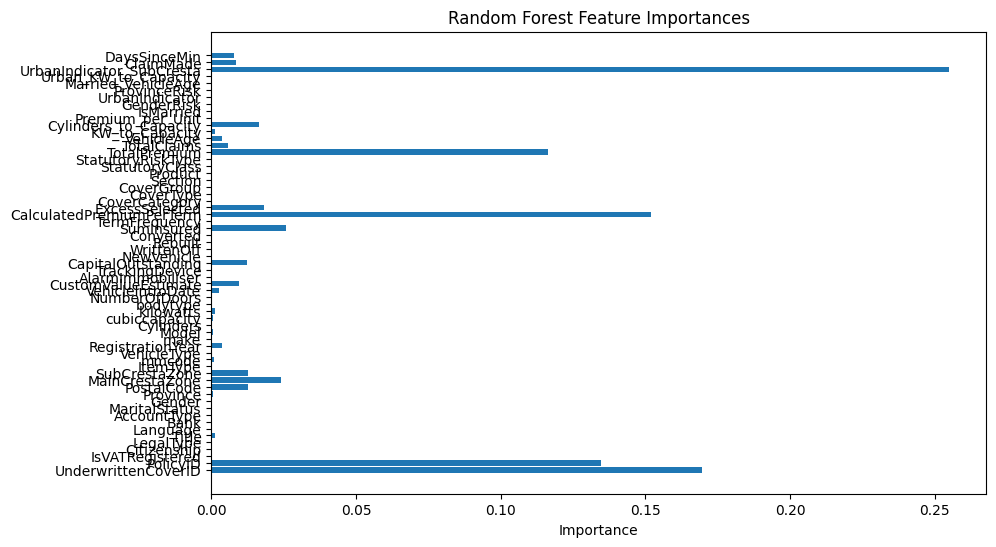

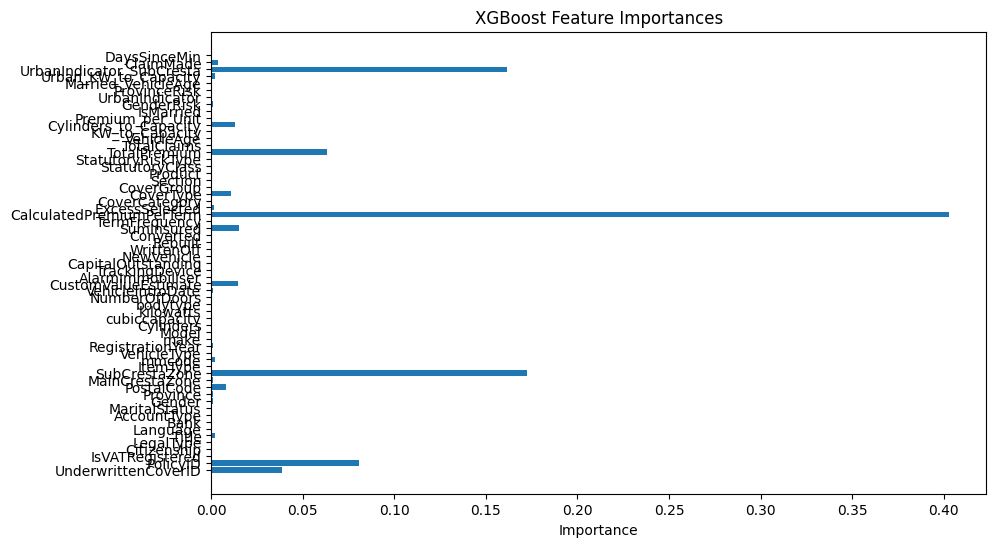

In [50]:
# Evaluation Metrics
def evaluate_model(model, X_test, y_test, model_name):
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mse)

    print(f"{model_name} Evaluation:")
    print(f"MSE: {mse}")
    print(f"R²: {r2}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("-" * 40)

# Evaluate each model
evaluate_model(lr_model, X_test, y_test, "Linear Regression")
evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(xgb_model, X_test, y_test, "XGBoost")

# Feature Importance Visualization for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(df.columns[:-1], rf_feature_importance)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.show()

# Feature Importance Visualization for XGBoost
plt.figure(figsize=(10, 6))
plt.barh(df.columns[:-1], xgb_feature_importance)
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.show()


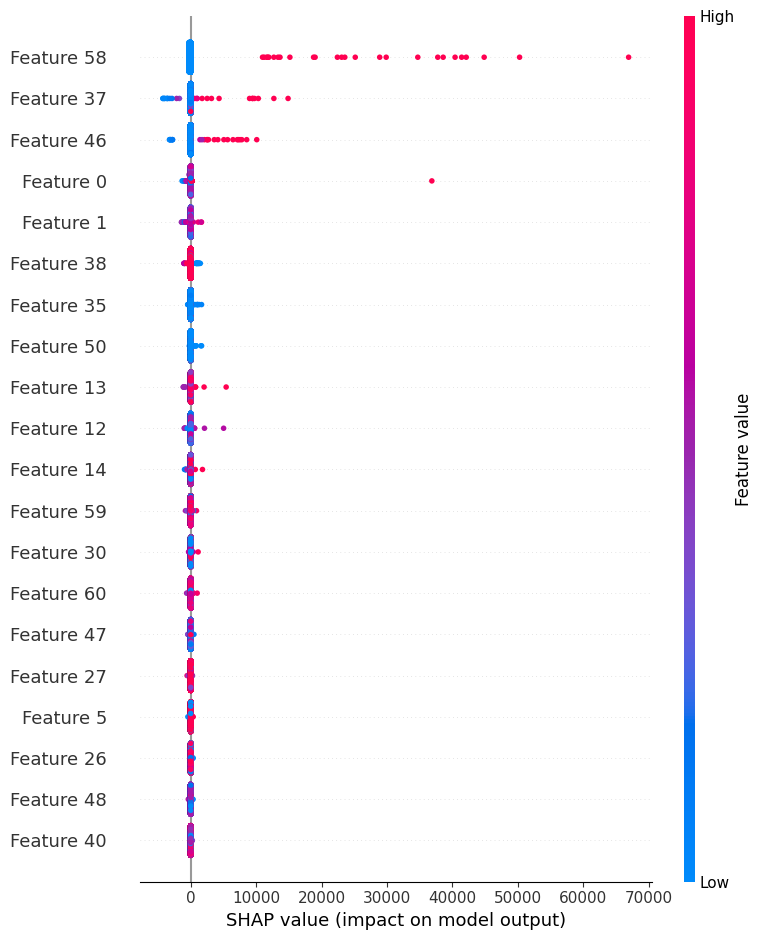

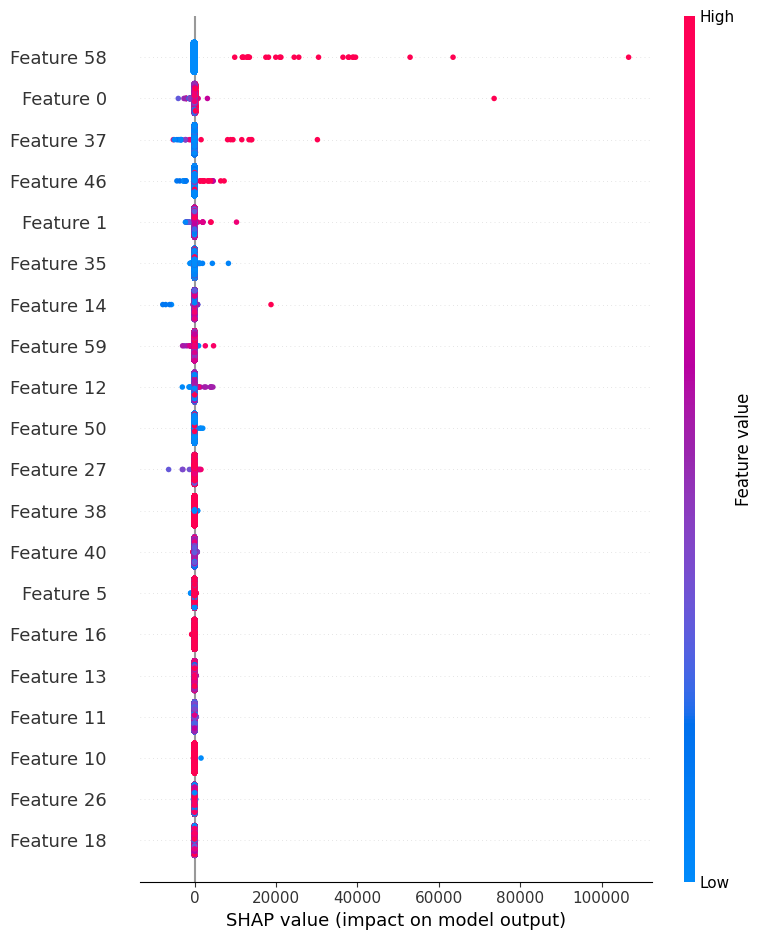

In [51]:
# SHAP Analysis for Random Forest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# Plot SHAP summary plot for Random Forest
shap.summary_plot(shap_values_rf, X_test)

# SHAP Analysis for XGBoost with additivity check disabled
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test, check_additivity=False)

# Plot SHAP summary plot for XGBoost
shap.summary_plot(shap_values_xgb, X_test)